# 1. Preprocess image

- Load an image and its corresponding groundtruth in 
- Get the indices of pixels labelled as road in the groundtruth (these will be our region of interests - ROI)
- Verify that the ROIs are correct

# 2. Initialise SegGradCam class

This class takes in an image of our choice, the class that we want to target, a receptive field to search in, the output layer and the layer from which we want to visualise the gradient of. 

- Initialise SegGradCam class
- Forward feed image
- Visualise results

- Additional notes:
    - alpha_c: Weight given to chosen class c to denote its importance
    - y_c: Logits for the chosen class c

## Get model

In [3]:
import os 
import sys

sys.path.append(os.path.join(os.getcwd(), '..', 'seg_grad_cam'))
from seg_grad_cam import *
from visualise_sgc import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from cbam_unet import *

# initialise model
input_shape = (None, 400, 400, 3)
cbam_unet_model = CBAM_UNet(input_shape)
cbam_unet_model.build(input_shape) # input shape: (None, 400, 400, 3)
# cbam_unet_model.summary()

for layer in cbam_unet_model.layers:
    print(layer._name)

cbam_depth1
cbam_depth2
cbam_depth3
cbam_depth4
encoder_depth1
encoder_depth2
encoder_depth3
encoder_depth4
encoder_depth5
convtranspose_depth5
convtranspose_depth4
convtranspose_depth3
convtranspose_depth2
decoder_depth4
decoder_depth3
decoder_depth2
output_block


## Get image

In [5]:
train_batch_size = 8 # change back to 8 later
val_batch_size = 10 # change back to 10 later
img_height = 400
img_width = 400
num_channels = 3

seed = 1
imgs_dir = os.path.join(os.path.dirname(os.getcwd()), 'datasets/train/image')
labels_dir = os.path.join(os.path.dirname(os.getcwd()), 'datasets/train/groundtruth')

# imgs_dir = os.path.join(os.path.dirname(os.getcwd()), 'input', 'road-segmentation-ds', 'training', 'images')
# labels_dir = os.path.join(os.path.dirname(os.getcwd()), 'input', 'road-segmentation-ds', 'training', 'groundtruth')

# Equivalent to x_train
train_imgs_ds = tf.keras.utils.image_dataset_from_directory(
  imgs_dir,
  validation_split=0.1,
  subset="training",
  seed=seed,
  labels=None,
  image_size=(img_height, img_width),
  batch_size=train_batch_size)

# Equivalent to x_val
val_imgs_ds = tf.keras.utils.image_dataset_from_directory(
  imgs_dir,
  validation_split=0.1,
  subset="validation",
  seed=seed,
  labels=None,
  image_size=(img_height, img_width),
  batch_size=val_batch_size)

# Equivalent to y_train
train_gts_ds = tf.keras.utils.image_dataset_from_directory(
  labels_dir,
  color_mode="grayscale",
  validation_split=0.1,
  subset="training",
  labels=None,
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=train_batch_size)

# Equivalent to y_val
val_gts_ds = tf.keras.utils.image_dataset_from_directory(
  labels_dir,
  color_mode="grayscale",
  validation_split=0.1,
  subset="validation",
  seed=seed,
  labels=None,
  image_size=(img_height, img_width),
  batch_size=val_batch_size)

Found 100 files belonging to 1 classes.
Using 90 files for training.
Found 100 files belonging to 1 classes.
Using 10 files for validation.
Found 100 files belonging to 1 classes.
Using 90 files for training.
Found 100 files belonging to 1 classes.
Using 10 files for validation.


In [6]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_imgs_ds = train_imgs_ds.map(lambda x: (normalization_layer(x)))
val_imgs_ds = val_imgs_ds.map(lambda x: (normalization_layer(x)))

train_gts_ds = train_gts_ds.map(lambda x: (normalization_layer(x)))
val_gts_ds = val_gts_ds.map(lambda x: (normalization_layer(x)))

In [7]:
batched_train_imgs = list(iter(train_imgs_ds))
sample_img = batched_train_imgs[0][0]
sample_img = sample_img.numpy()
print(sample_img.shape)

batched_train_gts = list(iter(train_gts_ds))
sample_gt = batched_train_gts[0][0]
sample_gt = sample_gt.numpy()
print(sample_gt.shape)

(400, 400, 3)
(400, 400, 1)


In [8]:
# Build the model graph to freely access output of each layer
input_shape = (None, 400, 400, 3)
cbam_unet_model = CBAM_UNet(input_shape)
inputs = tf.keras.Input(shape=input_shape[1:])
cbam_unet_model.call(inputs)

cbam_unet_model.built = True
cbam_unet_model.load_weights('cbam_unet_weights.h5') # include later

for i in cbam_unet_model.layers:
    print(i.output)

KerasTensor(type_spec=TensorSpec(shape=(None, 400, 400, 64), dtype=tf.float32, name=None), name='cbam_depth1/multiply_1/mul:0', description="created by layer 'cbam_depth1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 200, 200, 128), dtype=tf.float32, name=None), name='cbam_depth2/multiply_1/mul:0', description="created by layer 'cbam_depth2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100, 100, 256), dtype=tf.float32, name=None), name='cbam_depth3/multiply_1/mul:0', description="created by layer 'cbam_depth3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 50, 50, 512), dtype=tf.float32, name=None), name='cbam_depth4/multiply_1/mul:0', description="created by layer 'cbam_depth4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 400, 400, 64), dtype=tf.float32, name=None), name='encoder_depth1/conv2d_39/Relu:0', description="created by layer 'encoder_depth1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 200, 200, 128), dtype=tf.float32, name=None), name='encoder_depth2/conv2d_41/

In [9]:
print(cbam_unet_model.get_layer("decoder_depth4").output)
print(cbam_unet_model.get_layer("output_block").output)

KerasTensor(type_spec=TensorSpec(shape=(None, 50, 50, 512), dtype=tf.float32, name=None), name='decoder_depth4/conv_layer2/Relu:0', description="created by layer 'decoder_depth4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 400, 400, 1), dtype=tf.float32, name=None), name='output_block/outpublock_conv1dlayer/Sigmoid:0', description="created by layer 'output_block'")


In [10]:
'''
input_model: cbam_unet_model with loaded weights

image: actual image to produce gradient visualisation for

gt: actual gt of image gradient visualisation is produced for

cls: 1; this refers to the which channel in the output of the last
layer since normally each layer has it own class. In our case, our
final layer only has one channel so using cls = 1 is fine.

prop_to_layer: layer to get feature maps of interest

prop_from_layer: final layer with sigmoid activation

roi: Not given as an argument to use default value, where
the gradients are explained for the entire image

normalize: True; to normalise the gradients after the Seg Grad CAM
is generated

abs_w = False; whether to use absolute function on alpha_c

posit_w = False; whether to use relu on alpha_c, to clip negative gradients associated with the class
'''

# Initialise seg_grad_cam class
# seg_grad_cam = SegGradCAM(...)
seg_grad_cam = SegGradCAM(cbam_unet_model, sample_img, sample_gt, 'decoder_depth4', 'output_block')

# Get activation maP
activation_map = seg_grad_cam.SGC()

(1, 400, 400, 1)
tf.Tensor(
[[[[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  ...

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]]], shape=(1, 400, 400, 1), dtype=float32)
tf.Tensor(
[[[8.4856814e-01]
  [8.8806856e-01]
  [8.6048007e-01]
  ...
  [9.2257577e-01]
  [9.0741122e-01]
  [8.3887315e-01]]

 [[9.1563344e-01]
  [9.3474746e-01]
  [9.1451317e-01]
  ...
  [9.5645714e-01]
  [9.4837338e-01]
  [9.1007060e-01]]

 [[9.3081731e-01]
  [9.4622654e-01]
  [9.2300272e-01]
  ...
  [9.4848132e-01]
  [9.4791216e-01]
  [9.1358143e-01]]

 ...

 [[9.1737312e-01]
  [9.4403023e-01]
  [9.4865716e-01]
  ...
  [2.1407841e-05]
  [1.0450999e-05]
  [6.6571687e-05]]

 [[9.0377724e-01]
  [9.4211119e-01]
  [9.4926876e-01]
  ...
  [3.7109374e-05]
  [4.3429482e-05]
  [2.

In [11]:
# print(seg_grad_cam.roi)
# print(seg_grad_cam.image)

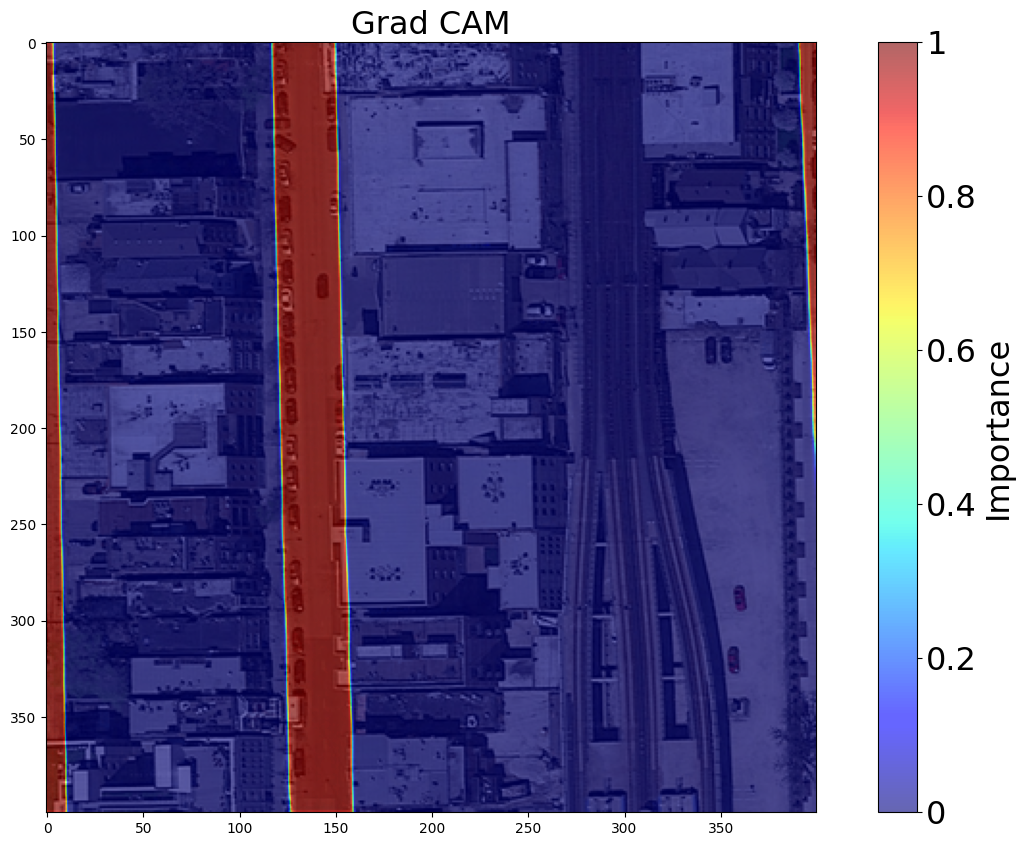

In [12]:
seg_grad_cam_plot = SegGradCAMplot(seg_grad_cam)

seg_grad_cam_plot.roi.image = seg_grad_cam_plot.image
seg_grad_cam_plot.explainBase('Grad CAM', '', 'grad_cam_sample')